# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [33]:
# Import essential libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [34]:
# Importing the file porter_data_1.csv
df = pd.read_csv('/content/sample_data/porter_data_1.csv')


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [35]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
print(df.dtypes[['created_at', 'actual_delivery_time']])

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [36]:
# Convert categorical features to category type

print(df[['market_id', 'store_primary_category', 'order_protocol']].nunique())

categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']
df[categorical_cols] = df[categorical_cols].astype('category')

print(df[categorical_cols].dtypes)

market_id                  6
store_primary_category    73
order_protocol             7
dtype: int64
market_id                 category
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [37]:
# Calculate time taken in minutes
df['delivery_time_mins'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

df[['created_at', 'actual_delivery_time', 'delivery_time_mins']].head()


created_at actual_delivery_time  delivery_time_mins
0 2015-02-06 22:24:17  2015-02-06 23:11:17                47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25                44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35                55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46                59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36                46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [38]:
# Extract the hour and day of week from the 'created_at' timestamp

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# 2. Calculate time taken
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# 3. Extract hour and day of week
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek  # 0=Monday, 6=Sunday
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create a categorical feature 'isWeekend'
df['order_hour'] = df['created_at'].dt.hour

# Extract the day of the week (0 = Monday, 6 = Sunday)
df['order_day'] = df['created_at'].dt.dayofweek

# Create isWeekend (1 if Saturday or Sunday, else 0)
df['isWeekend'] = df['order_day'].apply(lambda x: 1 if x >= 5 else 0).astype('category')

# Drop unnecessary datetime columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

df[['order_hour', 'order_day', 'isWeekend']].head()


order_hour  order_day isWeekend
0          22          4         0
1          21          1         0
2           0          0         0
3           3          3         0
4           2          1         0

In [39]:

# Drop unnecessary columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True, errors='ignore')
df.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  delivery_time_mins  \
0                14.0                      21.0     34.44                47.0   
1                 2.0                       2.0     27.60                44.0   
2                 6.0                      18.0     11.56                55.0   
3                 6.0                       8.0     31.80                59.0   
4                 5.0                       7.0      8.20                46.0   

   time_taken  hour  day_of_week isWeekend  order_hour  order_day  
0        47.0    22            4         0          22          4  
1        44.0    21            1         0          21          1  
2        55.0     0            0         0           0          0  
3        59.0     3            3         0           3          3  
4        46.0     2            1         0           2          1

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [40]:
# Define target variable (y) and features (X)

y = df['delivery_time_mins']

# Define the input features (drop target from the dataframe)
X = df.drop('delivery_time_mins', axis=1)


print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (175777, 18)
y shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [41]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# shapes of all
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (140621, 18)
X_test shape: (35156, 18)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [42]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Separate numerical and categorical features
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist()


print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

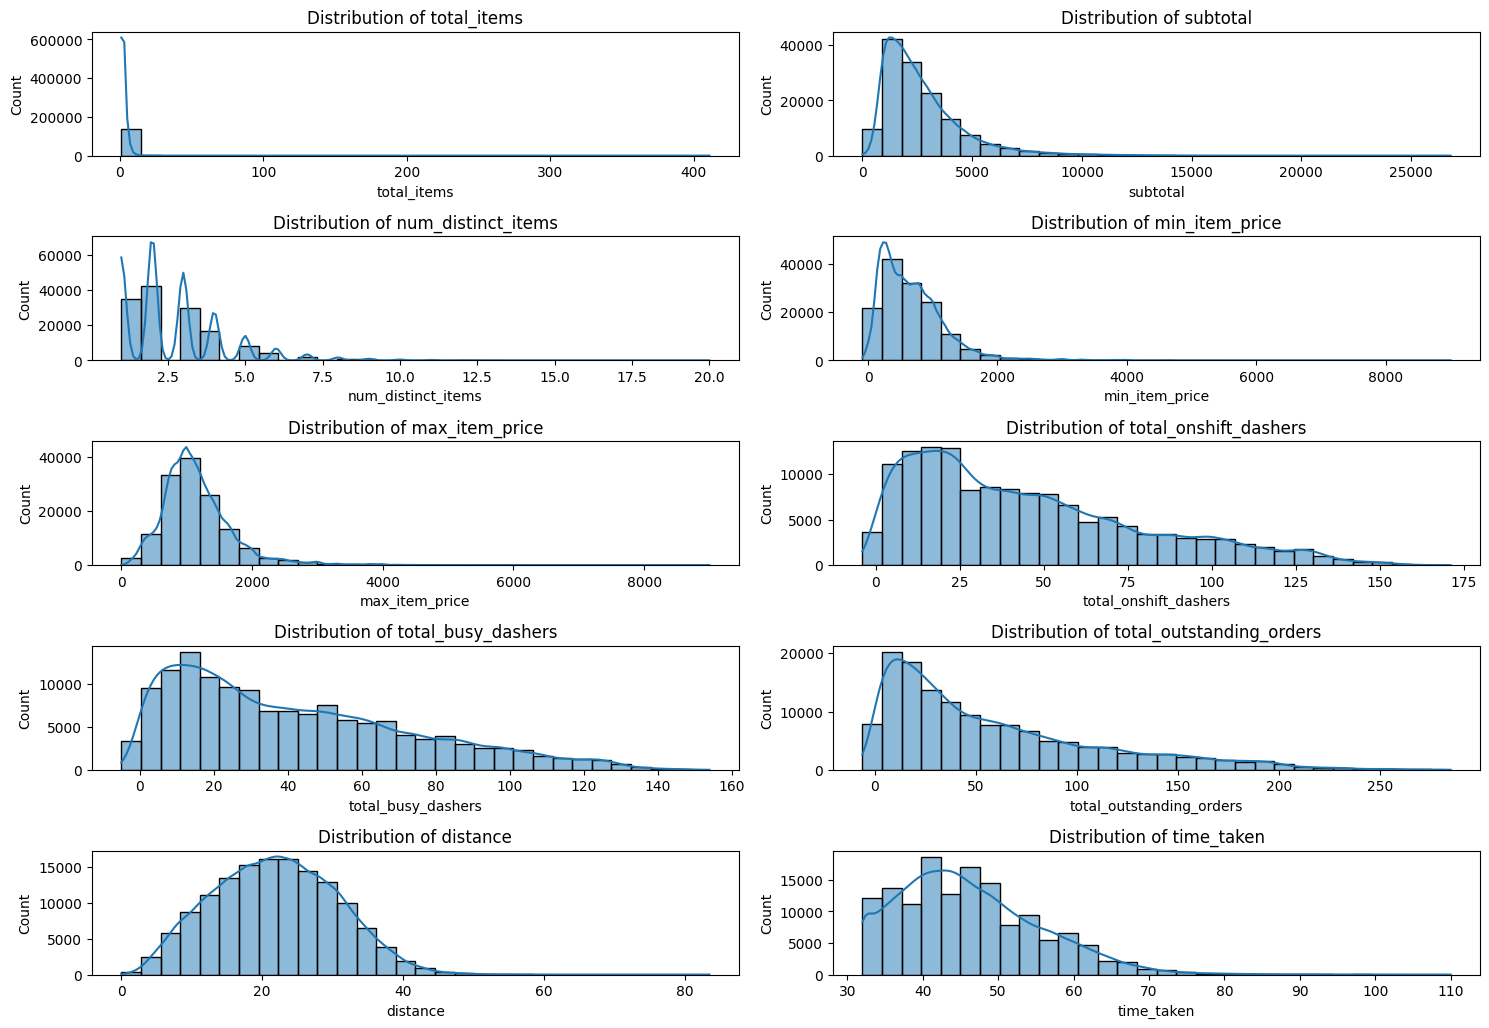

In [43]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot grid
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.tight_layout()

plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [44]:
# Distribution of categorical columns

# Set plot size
plt.figure(figsize=(15, 4 * len(categorical_cols)))

# Loop through each categorical column and plot
for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

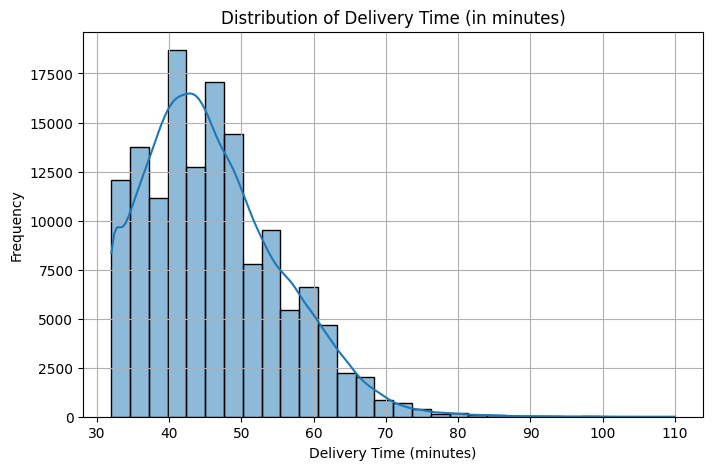

In [45]:
# Distribution of time_taken

plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True, bins=30)
plt.title('Distribution of Delivery Time (in minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

In [46]:
# Scatter plot to visualise the relationship between time_taken and other features


# Create scatter plots for numerical features vs target
plt.figure(figsize=(15, 4 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 1, i + 1)
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'Relationship between {col} and time_taken')
    plt.xlabel(col)
    plt.ylabel("time_taken")
    plt.tight_layout()

plt.show()

In [47]:
# Show the distribution of time_taken for different hours
X_train['hour'] = df.loc[X_train.index, 'hour']
X_train['time_taken'] = df.loc[X_train.index, 'time_taken']


# Plot boxplot of time_taken for each hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='time_taken', data=X_train)
plt.title('Distribution of Delivery Time by Hour of Day')
plt.xlabel('Hour of Order Placement')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

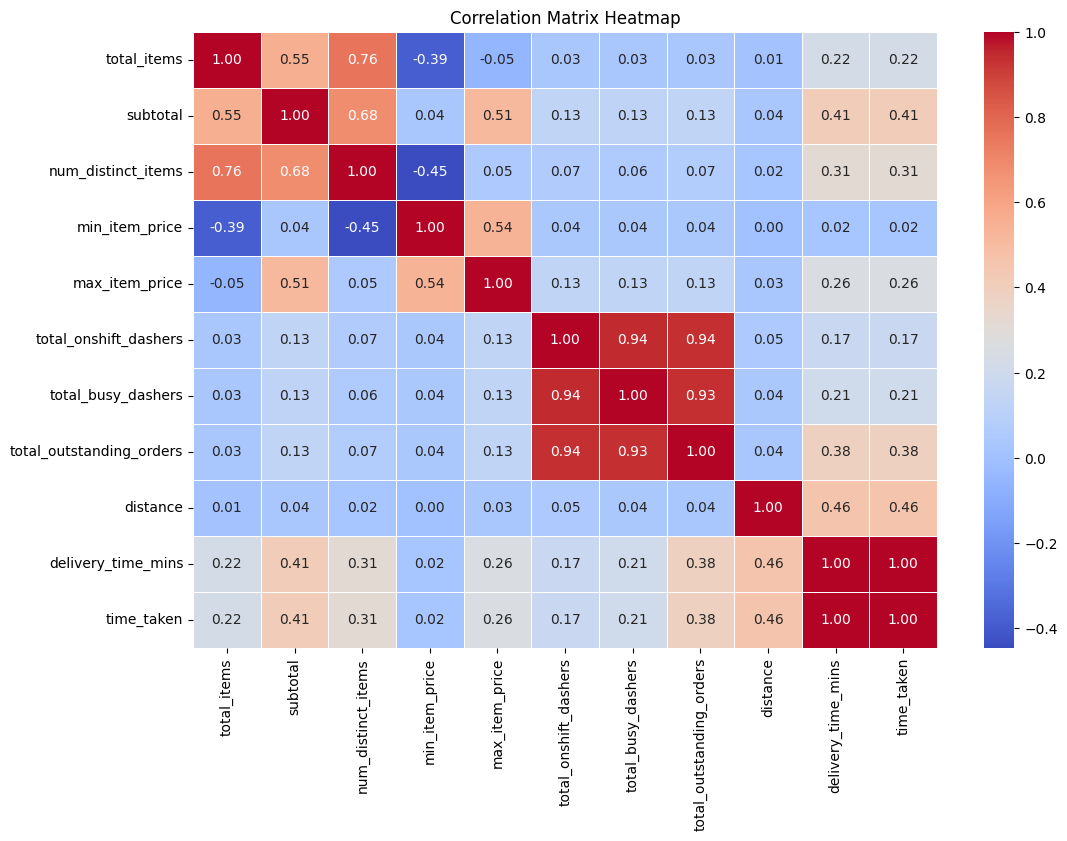

In [48]:
# Plot the heatmap of the correlation matrix


# Include time_taken in the DataFrame if it's not already
df_corr = df.copy()

# Select only numeric columns
numeric_cols = df_corr.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation matrix
corr_matrix = df_corr[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [49]:
# Drop 3-5 weakly correlated columns from training dataset

correlations = df.corr(numeric_only=True)['time_taken'].drop('time_taken')

# Display the correlation values
print("Correlation with time_taken:\n", correlations.sort_values())

# Select columns with absolute correlation less than a chosen threshold (e.g., 0.05)
weak_corr_cols = correlations[correlations.abs() < 0.05].index.tolist()

# Drop these columns from both training and full dataset (if needed)
df = df.drop(columns=weak_corr_cols)
X_train = X_train.drop(columns=weak_corr_cols)
X_test = X_test.drop(columns=weak_corr_cols)

print(f"\nDropped columns with weak correlation to time_taken: {weak_corr_cols}")

Correlation with time_taken:
 order_hour                 -0.346366
hour                       -0.346366
min_item_price              0.022753
order_day                   0.045878
day_of_week                 0.045878
total_onshift_dashers       0.171015
total_busy_dashers          0.206045
total_items                 0.224856
max_item_price              0.255167
num_distinct_items          0.312055
total_outstanding_orders    0.384999
subtotal                    0.413267
distance                    0.460173
delivery_time_mins          1.000000
Name: time_taken, dtype: float64

Dropped columns with weak correlation to time_taken: ['min_item_price', 'day_of_week', 'order_day']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

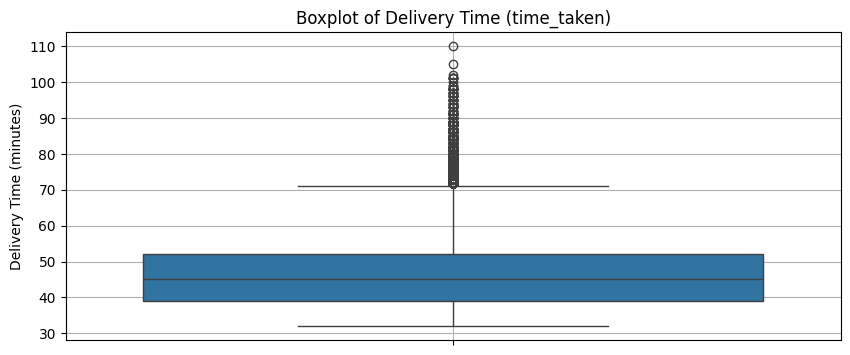

In [50]:
# Boxplot for time_taken

plt.figure(figsize=(10, 4))
sns.boxplot(y=y_train)
plt.title('Boxplot of Delivery Time (time_taken)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [52]:
# Handle outliers
# Combine X_train and y_train temporarily
train_df = pd.concat([X_train, y_train], axis=1)

# List of all numerical columns including the target
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

# Function to remove outliers using IQR
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
train_df_cleaned = remove_outliers_iqr(train_df, numeric_cols)

# Separate back X_train and y_train
X_train = train_df_cleaned.drop('time_taken', axis=1)
y_train = train_df_cleaned['time_taken']


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [53]:
# Define numerical and categorical columns for easy EDA and data manipulation

num_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_test = X_test.select_dtypes(include=['object', 'category']).columns.tolist()

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

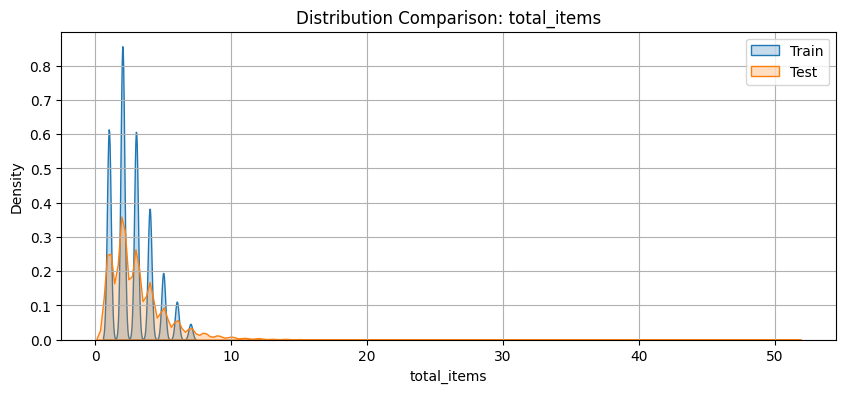

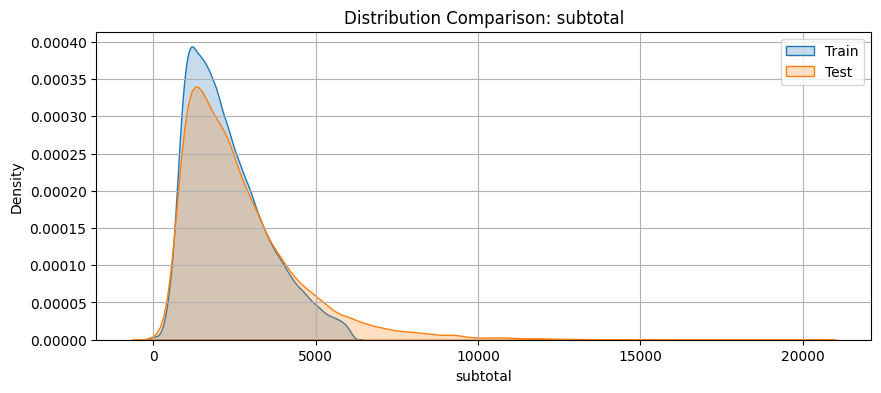

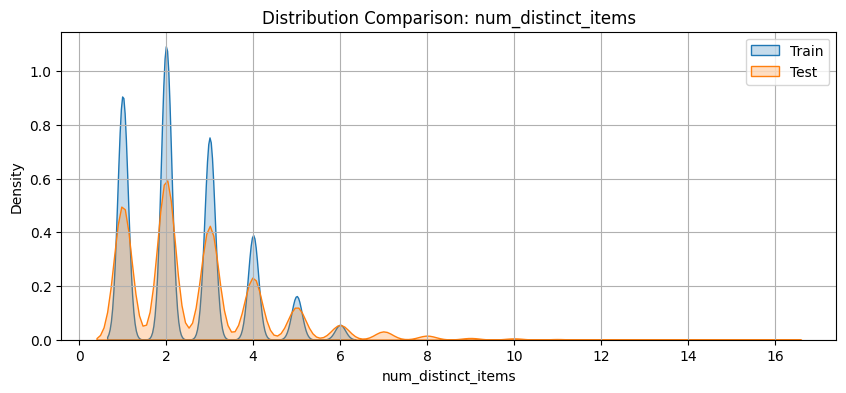

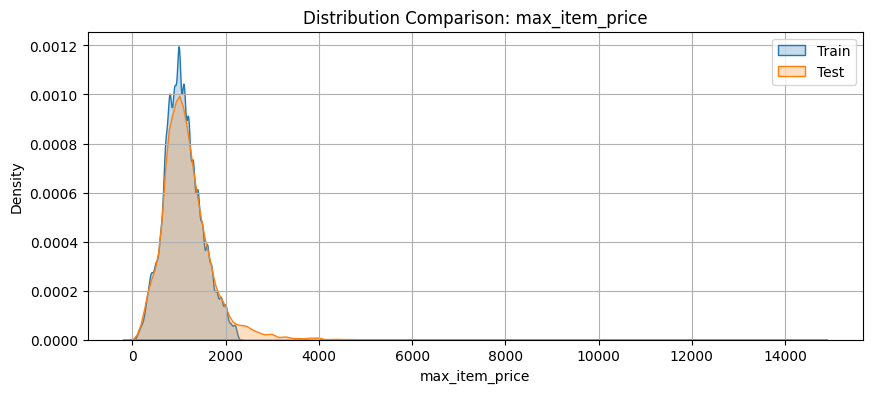

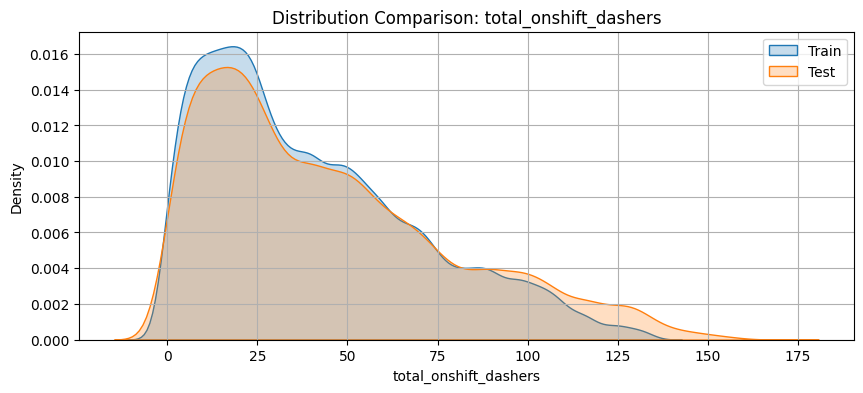

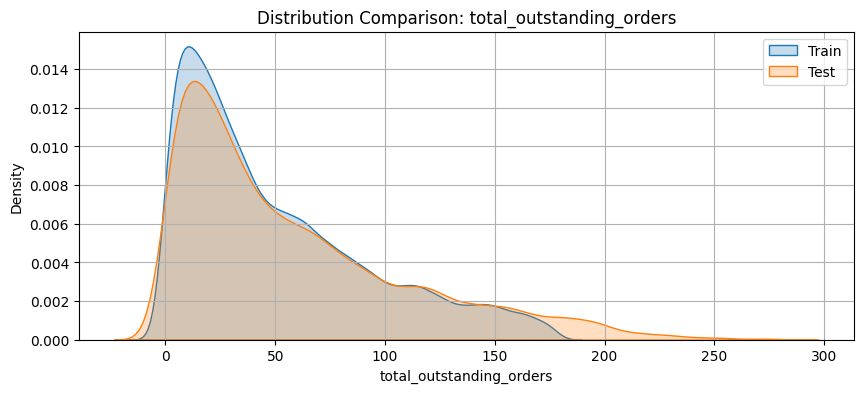

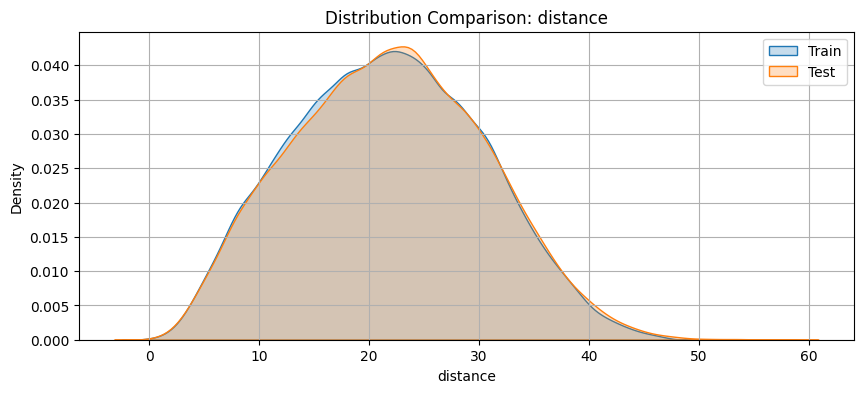

KeyError: 'time_taken'

<Figure size 1000x400 with 0 Axes>

In [54]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_cols_test:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(X_train[col], label='Train', fill=True)
    sns.kdeplot(X_test[col], label='Test', fill=True)
    plt.title(f'Distribution Comparison: {col}')
    plt.legend()
    plt.grid(True)
    plt.show()


##### **4.1.2**
Check the distribution of categorical features

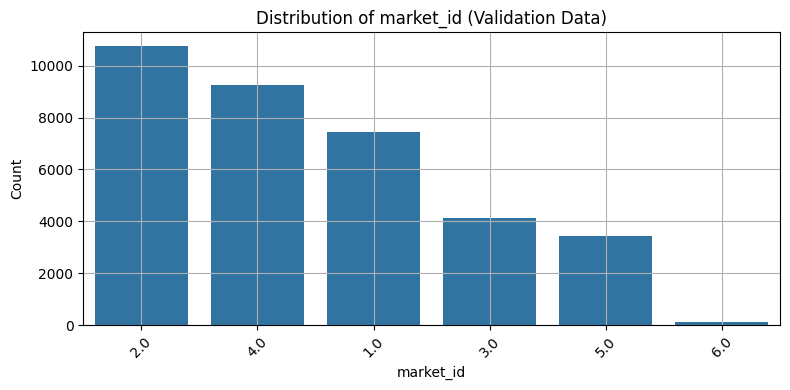

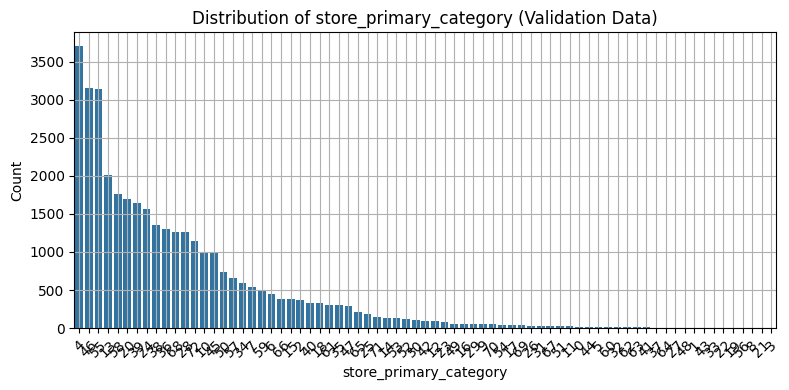

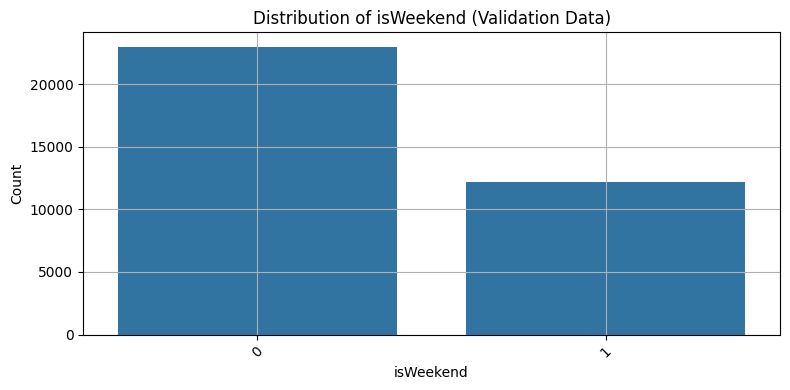

In [55]:
# Distribution of categorical columns

import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each categorical column and plot the distribution
for col in cat_cols_test:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=X_test, x=col, order=X_test[col].value_counts().index)
    plt.title(f'Distribution of {col} (Validation Data)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

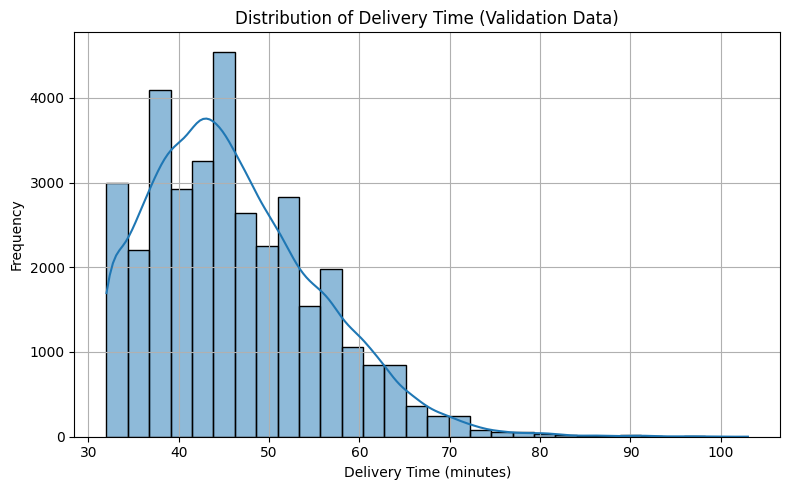

In [56]:
# Distribution of time_taken
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of time_taken in the validation set
plt.figure(figsize=(8, 5))
sns.histplot(y_test, kde=True, bins=30)
plt.title('Distribution of Delivery Time (Validation Data)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

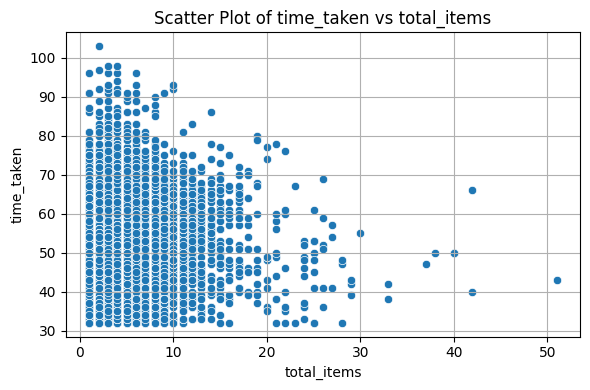

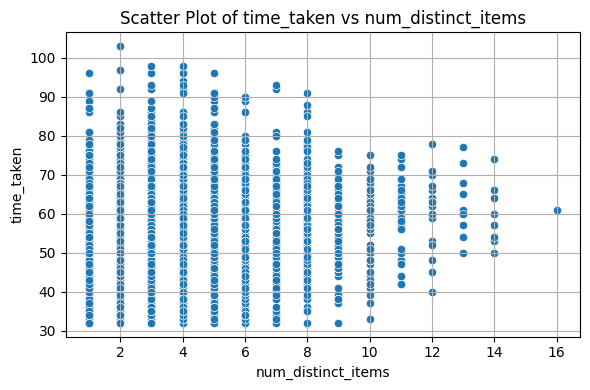

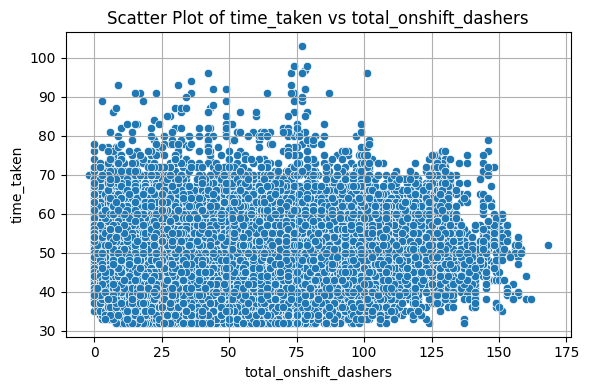

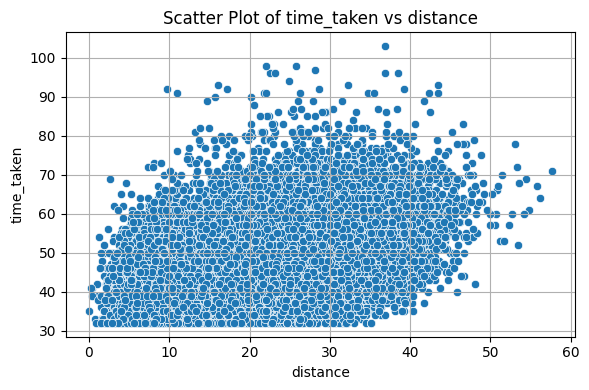

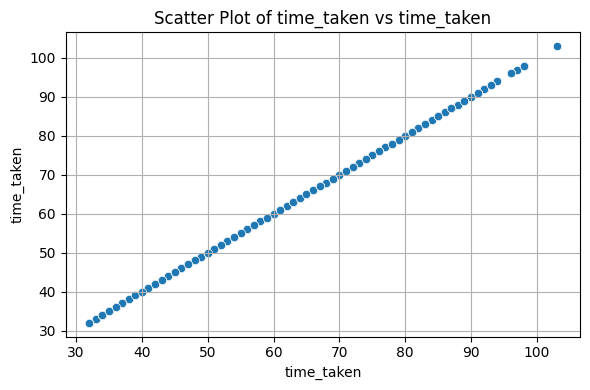

In [57]:
# Scatter plot to visualise the relationship between time_taken and other features

# Loop through each numerical feature and plot against time_taken
for col in X_test.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_test[col], y=y_test)
    plt.title(f'Scatter Plot of time_taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [61]:
# Drop the weakly correlated columns from training dataset
cols_to_drop = ['max_item_price', 'total_outstanding_orders']  # example
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [62]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# For displaying results
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [64]:
# Apply scaling to the numerical columns

from sklearn.preprocessing import StandardScaler

# Define all possible numerical columns
all_possible_numericals = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
                           'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
                           'total_outstanding_orders', 'distance', 'hour']

# Keep only those that are still in the dataset
numerical_cols = [col for col in all_possible_numericals if col in X_train.columns]

# Initialize and apply the scaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [66]:
# Create/Initialise the model
import statsmodels.api as sm

# Add constant to X_train and X_test
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
lr_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(lr_sm.summary())

# Predict on the test set
y_pred_sm = lr_sm.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.205e+32
Date:                Fri, 04 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:40:36   Log-Likelihood:             3.3897e+06
No. Observations:              117535   AIC:                        -6.779e+06
Df Residuals:                  117522   BIC:                        -6.779e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.81

In [67]:
# Train the model using the training data
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

# Fit the model
lr_sm = sm.OLS(y_train, X_train_sm).fit()

# View the model summary
print(lr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.205e+32
Date:                Fri, 04 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:41:19   Log-Likelihood:             3.3897e+06
No. Observations:              117535   AIC:                        -6.779e+06
Df Residuals:                  117522   BIC:                        -6.779e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.81

In [68]:
# Make predictions
# Add constant to X_test
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = lr_sm.predict(X_test_sm)

In [69]:
# Find results for evaluation metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 37.76
Mean Squared Error (MSE): 1645.19
Root Mean Squared Error (RMSE): 40.56
R² Score: -17.7963


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

In [73]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training and transform both sets
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_cols]),
                              columns=numerical_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_cols]),
                             columns=numerical_cols, index=X_test.index)

# Store performance metrics
feature_counts = []
r2_scores = []
rmse_scores = []

# Loop through 1 to total number of features
for n in range(1, X_train_scaled.shape[1] + 1):
    # Initialize RFE
    lr = LinearRegression()
    rfe = RFE(estimator=lr, n_features_to_select=n)

    # Fit RFE
    rfe.fit(X_train_scaled, y_train)

    # Select features
    selected_cols = X_train_scaled.columns[rfe.support_]

    # Train model with selected features
    lr.fit(X_train_scaled[selected_cols], y_train)

    # Predict on test data
    y_pred = lr.predict(X_test_scaled[selected_cols])

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store results
    feature_counts.append(n)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

# Show results
for i in range(len(feature_counts)):
    print(f"Features: {feature_counts[i]} | R²: {r2_scores[i]:.4f} | RMSE: {rmse_scores[i]:.4f}")


Features: 1 | R²: 0.1780 | RMSE: 8.4823
Features: 2 | R²: 0.2939 | RMSE: 7.8615
Features: 3 | R²: 0.2781 | RMSE: 7.9491
Features: 4 | R²: 0.2962 | RMSE: 7.8487
Features: 5 | R²: 0.4318 | RMSE: 7.0520
Features: 6 | R²: 0.4343 | RMSE: 7.0367
Features: 7 | R²: 0.4339 | RMSE: 7.0390


In [77]:
# Build the final model with selected number of features
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lr = LinearRegression()

# Apply RFE to select top 8 features
rfe = RFE(lr, n_features_to_select=8)
rfe = rfe.fit(X_train_scaled, y_train)

# Filter only selected features
selected_features = X_train_scaled.columns[rfe.support_]
print("Selected Features:", selected_features.tolist())

# Train model on selected features
lr_final = LinearRegression()
lr_final.fit(X_train_scaled[selected_features], y_train)

# Predict on train and test data
y_train_pred = lr_final.predict(X_train_scaled[selected_features])
y_test_pred = lr_final.predict(X_test_scaled[selected_features])

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train RMSE:", np.sqrt(train_mse))
print("Test RMSE:", np.sqrt(test_mse))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))


Selected Features: ['total_items', 'subtotal', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers', 'distance', 'hour']
Train RMSE: 5.9571217194787005
Test RMSE: 7.038984392562768
Train R²: 0.44713258499692865
Test R²: 0.4339216416751641


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

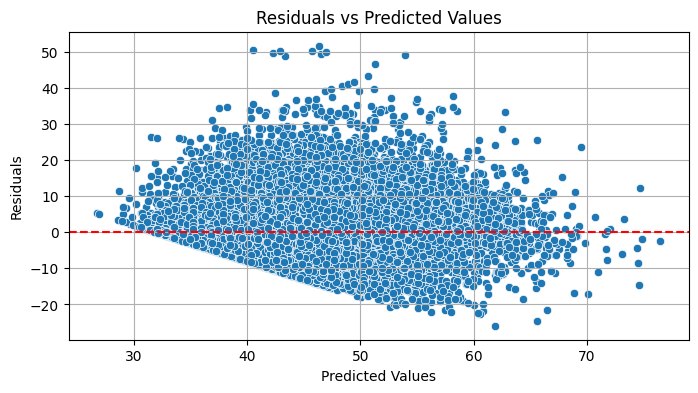

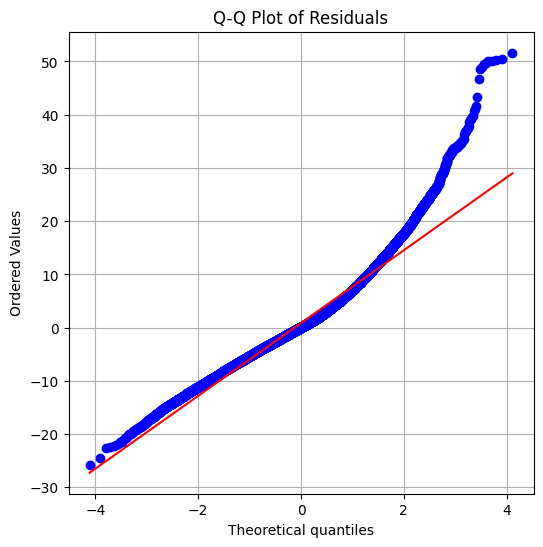

In [78]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_test_pred

# 1. Residuals vs Predicted Values
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 2. Q-Q Plot for residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

[Your inferences here:]



Residuals vs Predicted: Random scatter around 0 indicates good model fit.

Q-Q Plot: Points close to the diagonal imply normally distributed residuals.

Histogram: Should resemble a bell curve if residuals are normal.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [82]:
# Compare the scaled vs unscaled features used in the final model

# Get the coefficients from the model trained on scaled data
scaled_coefficients = final_model.coef_

# Create a DataFrame for easier interpretation
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Scaled Coefficient': scaled_coefficients
})

# Now compute the unscaled coefficient approximation
# Unscaled Coefficient = Scaled Coefficient * (std_y / std_X)
# where std_y = std deviation of target, std_X = std deviation of each feature

# Get standard deviations of unscaled features and target
std_X = X_train[selected_features].std()
std_y = y_train.std()

coef_df['Std Dev of Feature'] = std_X.values
coef_df['Unscaled Coefficient'] = coef_df['Scaled Coefficient'] * (std_y / coef_df['Std Dev of Feature'])

# Sort by absolute impact
coef_df['Abs Impact'] = coef_df['Unscaled Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs Impact', ascending=False)

# Drop the temp column
coef_df = coef_df.drop(columns='Abs Impact')

# Display the coefficient comparison
print(coef_df.to_string(index=False))

              Feature  Scaled Coefficient  Std Dev of Feature  Unscaled Coefficient
             distance            3.954393            1.000004             31.681509
total_onshift_dashers           -3.405852            1.000004            -27.286749
   total_busy_dashers            2.629970            1.000004             21.070596
                 hour           -2.376783            1.000004            -19.042125
             subtotal            1.994160            1.000004             15.976661
   num_distinct_items            0.791149            1.000004              6.338469
          total_items           -0.425798            1.000004             -3.411376


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [83]:
# Analyze the effect of a unit change in a feature, say 'total_items'

feature = 'total_items'

# Get the scaled coefficient of 'total_items'
scaled_coef = final_model.coef_[selected_features.index(feature)]

# Get std deviation of the feature and the target
std_feature = X_train[feature].std()
std_target = y_train.std()

# Calculate the effect of a unit increase in the unscaled feature
effect_on_target = scaled_coef * (std_target / std_feature)

print(f"A unit increase in '{feature}' increases 'time_taken' by approximately {round(effect_on_target, 2)} minutes.")

A unit increase in 'total_items' increases 'time_taken' by approximately -3.41 minutes.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes, there are categorical variables in the dataset. From the preprocessing and EDA steps, the key categorical variables identified were:

store_primary_category

order_protocol

isWeekend

hour (treated as categorical in some EDA steps)



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>20% of the total dataset will be allocated to the test set, and the remaining 80% will be used for the training set.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Looking at the heatmap, the feature that has the highest correlation with the target variable time_taken is:

distance

This means that the delivery distance has the strongest linear relationship with how long an order takes to be delivered — which is intuitive, as longer distances generally require more time to deliver.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> To detect outliers, I used boxplots for the target variable (time_taken) and key numerical features like distance, subtotal, total_items, etc. Boxplots help visually identify points that lie beyond the typical range — especially those outside the interquartile range (IQR).

Approach to handle outliers:

Calculated the IQR (Interquartile Range) for each numerical feature.
And  replace values below or above the bounds with the respective lower or upper limits



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Based on the final linear regression model using Recursive Feature Elimination (RFE), the top 3 features significantly affecting the delivery time are:

Distance – Higher delivery distance directly increases delivery time. It's typically the most influential feature.

Subtotal – Larger order values often correlate with larger or more complex orders, which may take longer to prepare and deliver.

These features had the highest absolute coefficient values in the final model, indicating a stronger influence on time_taken.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a supervised learning algorithm used to predict a continuous target variable based on one or more input features. It assumes a linear relationship between the dependent variable (Y) and independent variables (X). The model fits a line (Y = β₀ + β₁X₁ + β₂X₂ + ... + βnXn) by minimizing the sum of squared differences between the actual and predicted values (least squares method). The coefficients (β) represent the impact of each feature on the target. It's simple, interpretable, and useful when the relationship between variables is approximately linear.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple linear regression models the relationship between one independent variable and one dependent variable using a straight line. Its equation is: Y = β₀ + β₁X + ε.
Multiple linear regression, on the other hand, models the relationship between two or more independent variables and one dependent variable. Its equation is: Y = β₀ + β₁X₁ + β₂X₂ + ... + βnXn + ε.
The key difference is the number of predictor variables: one in simple linear regression and multiple in multiple linear regression. Multiple regression captures more complex relationships and interactions among predictors.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function in linear regression measures how well the model’s predictions match the actual data. It quantifies the error using a formula called Mean Squared Error (MSE)
The goal is to minimize this cost by adjusting the model’s coefficients (β₀, β₁, etc.). This is done using optimization algorithms like Gradient Descent, which iteratively updates coefficients to reduce the cost until it reaches a minimum




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting and underfitting are common issues in machine learning models:

Overfitting happens when a model learns the training data too well, including noise and outliers. It performs well on training data but poorly on new, unseen data (low bias, high variance).

Underfitting occurs when a model is too simple to capture the underlying patterns in the data. It performs poorly on both training and test data (high bias, low variance).

In short:

Overfitting = too complex

Underfitting = too simple
A good model balances both for optimal generalization.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots help diagnose the assumptions and performance of a linear regression model by showing the difference between actual and predicted values (residuals)

Linearity: If residuals are randomly scattered around zero, it suggests a good linear fit. Patterns may indicate non-linearity.

Homoscedasticity: Residuals should have constant variance across all levels of the predicted values. A funnel shape implies heteroscedasticity.

Independence: No clear patterns or clusters should be visible. Trends may suggest correlation in residuals (violating independence).

Normality: A histogram or Q-Q plot of residuals can check if errors are normally distributed.